In [75]:
import pandas as pd
from impyute.imputation.cs import mice#
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer#
import missingno as msno#
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.distance import squareform, pdist
from missingpy import KNNImputer
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set()
pd.set_option("display.max_rows", 8)
plt.rcParams['figure.figsize'] = (9, 6)
from missingpy import MissForest


In [2]:
Dapp = pd.read_csv("horse-colic.data" , sep = "\s+", names = ["V"+str(i) for i in range(28)])
Dtest = pd.read_csv("horse-colic.test" , sep = "\s+", names = ["V"+str(i) for i in range(28)])
liste_drop = ["V22","V23","V24","V25","V26","V27"]
Dapp = Dapp.drop(liste_drop , axis = 1)
Dtest = Dtest.drop(liste_drop , axis = 1)
Dapp = Dapp.replace("?",np.nan)
Dtest = Dtest.replace("?",np.nan)

#Dtest
#Dapp
#On utilisera une méthode d'imputation qui gère différentes types pour les variables ! (cf Référence)
#On se doit tout de même spécifier le type des variables


In [3]:
d = {}
liste_categorical = [] ; liste_numerical = []
for i in range(22):
    if(i in list(range(3)) + list(range(6 , 15)) + [16 , 17 , 20]):
        d["V"+str(i)] = "category"
        liste_categorical.append("V"+str(i))
    else:
        d["V"+str(i)] = "float64"
        liste_numerical.append("V"+str(i))
liste_categorical
liste_numerical

['V3', 'V4', 'V5', 'V15', 'V18', 'V19', 'V21']

In [215]:
Dapp = Dapp.astype(d)
Dtest = Dtest.astype(d)
Dapp_num = Dapp.select_dtypes(include=['float64']) ; Dapp_cat = Dapp.select_dtypes(include=['category'])
Dtest_num = Dtest.select_dtypes(include=['float64']) ; Dtest_cat = Dtest.select_dtypes(include=['category'])


In [5]:
def g(l):
    return np.array([float(x) for x in l])

imputed_training=mice(np.array(list(map(g , Dapp_num.values))))
imputed_test = mice(np.array(list(map(g , Dtest_num.values))))

Dapp_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputed_training))))).round(2)
Dapp_num_imputed.columns = liste_numerical

Dtest_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputed_test))))).round(2)
Dtest_num_imputed.columns = liste_numerical

In [6]:
## On a généré quelques valeurs négatives, il est nécessaire d'effectuer de nouvelles imputations sur nos données
Dapp_num_imputed[Dapp_num_imputed < 0] = np.nan
Dtest_num_imputed[Dtest_num_imputed < 0] = np.nan

distances_app = pdist(Dapp_num_imputed.values, metric='euclidean')
dist_matrix_app = squareform(distances_app)
matrice_distance_app = pd.DataFrame(list(map(np.ravel, (list(dist_matrix_app))))).round(2)

distances_test = pdist(Dtest_num_imputed.values, metric='euclidean')
dist_matrix_test = squareform(distances_test)
matrice_distance_test = pd.DataFrame(list(map(np.ravel, (list(dist_matrix_test))))).round(2)


In [7]:
matrice_distance_test
matrice_distance_app
## ici on décide de visualiser les distances pour savoir s'il y a de grandes différences en termes
#de distribution de la distance euclienne si on considère la distance euclidenne comme une variable quelconque
# les données négatives sont imputées en utilisant la méthode knn. Le choix du nombre de voisins sera arbitraire.
#on utilisera donc une imputation simple

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.00,80.38,28.97,112.94,48.34,17.13,23.12,6.10,17.73,29.54,...,55.29,23.21,13.03,55.25,65.80,89.46,15.89,16.39,34.82,60.96
1,80.38,0.00,93.60,126.30,84.26,64.01,88.82,82.39,81.78,83.10,...,51.45,82.78,82.62,26.37,53.06,62.85,65.13,81.21,80.08,55.08
2,28.97,93.60,0.00,138.59,76.82,39.39,12.02,23.24,42.07,54.42,...,53.19,49.43,26.46,67.96,61.07,111.45,37.36,42.31,62.45,55.73
3,112.94,126.30,138.59,0.00,81.74,107.75,134.93,118.18,97.29,84.48,...,146.30,93.26,117.80,118.51,154.00,74.49,110.99,107.38,87.83,150.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,15.89,65.13,37.36,110.99,47.66,7.23,30.47,19.03,22.53,31.81,...,45.46,28.78,19.31,40.17,55.99,79.81,0.00,23.19,33.01,51.80
297,16.39,81.21,42.31,107.38,35.30,22.15,36.07,20.16,24.20,30.53,...,62.01,17.31,27.62,58.53,73.40,85.67,23.19,0.00,30.47,69.06
298,34.82,80.08,62.45,87.83,26.84,34.22,54.27,40.82,26.35,24.76,...,76.48,28.92,37.42,60.62,86.96,77.68,33.01,30.47,0.00,83.40
299,60.96,55.08,55.73,150.50,93.63,51.87,55.91,58.59,70.64,78.88,...,10.53,74.96,61.05,38.87,6.68,96.29,51.80,69.06,83.40,0.00


In [8]:
#on ne peut pas se permettre de prendre des poids uniformes
#en effet, il se peut que le 2e plus proche soit en réalité très loin du point par rapport au premier

imputer = KNNImputer(n_neighbors=15, weights="distance")
Dapp_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputer.fit_transform(Dapp_num_imputed)))))).round(2)

imputer = KNNImputer(n_neighbors=3, weights="distance")
Dtest_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputer.fit_transform(Dtest_num_imputed)))))).round(2)

Dapp_num_imputed.columns = liste_numerical ; Dtest_num_imputed.columns = liste_numerical
#le choix du nombre de voisins est difficile, on fait donc des choix arbitraires


C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)


In [212]:
{lab : 1-(len(Dtest_num[lab].dropna())/len(Dtest_num)) for lab in liste_numerical} 
{lab : 1-(len(Dapp_num[lab].dropna())/len(Dapp_num)) for lab in liste_numerical} 


{'V3': 0.19999999999999996,
 'V4': 0.07999999999999996,
 'V5': 0.19333333333333336,
 'V15': 0.8233333333333334,
 'V18': 0.09666666666666668,
 'V19': 0.10999999999999999,
 'V21': 0.6599999999999999}

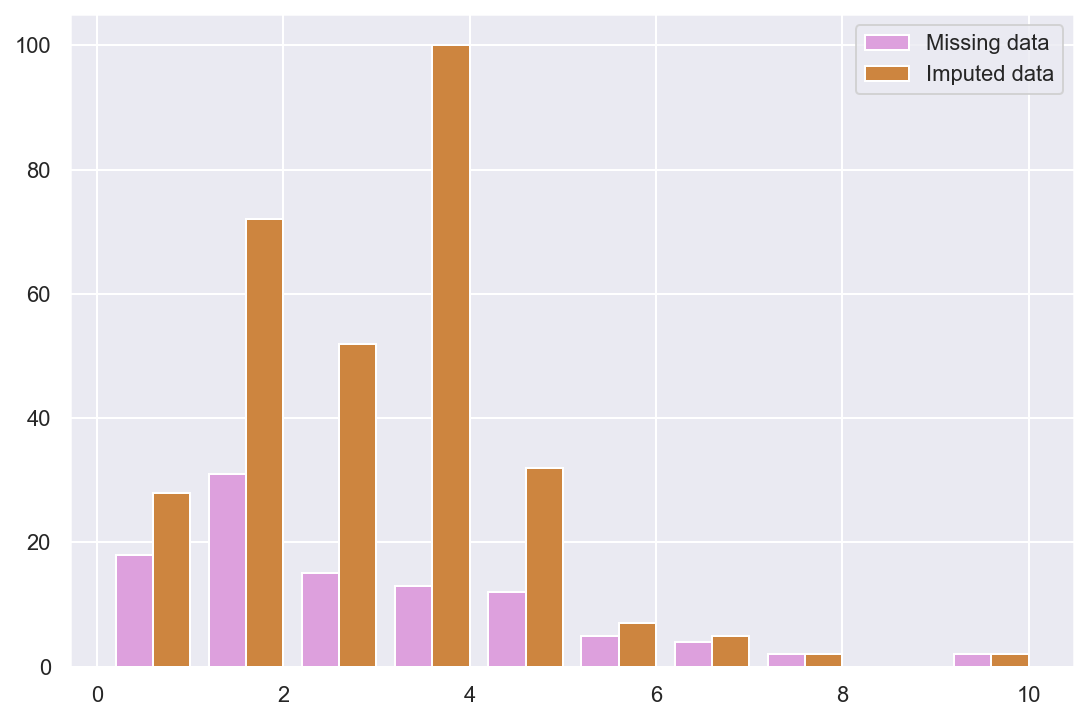

In [214]:
x = Dapp_num.V21
y = Dapp_num_imputed.V21
#L'objectif est de comparer les distributions pour voir si l'on observe une certaine cohérence après imputation
#on compare les distributions avant/après
#on calcule aussi la proportion de données manquantes pour être sûr que la comparaison ait un sens.
#il faut que le % de données manquantes ne soit ni trop faible ni trop élevé pour pouvoir comparer
#on peut faire une "évaluation" visuelle de notre imputation sur cette variable choisie
plt.hist([x, y], label=['Missing data', 'Imputed data'] , color = ["plum","peru"])
plt.legend(loc='upper right')
plt.show()

In [ ]:
##La varible ID hôpital sera supprimée, en pratique, une variable qualitative avec beaucoup de 
#modalités peut s'avérer très problèmatique, on décide de continuer notre modélisation sans cette variable


In [217]:
#Dapp_cat = Dapp_cat.drop(["V2"] , axis = 1) ; Dtest_cat = Dtest_cat.drop(["V2"] , axis = 1)
cat_cols = [Dapp_cat.columns.get_loc(col) for col in Dapp_cat.select_dtypes(['category']).columns.tolist()]

imputer = MissForest(random_state = 100)
Dapp_cat_imputed = imputer.fit_transform(Dapp_cat , cat_vars = cat_cols)
Dapp_cat_imputed = pd.DataFrame(list(map(np.ravel, (list(Dapp_cat_imputed)))))
Dapp_cat_imputed.columns = [x for x in liste_categorical] #if(x!="V2")
Dapp_cat_imputed = Dapp_cat_imputed.apply(lambda x : x.astype(int).astype(str).astype("category") , axis = 1)

imputer = MissForest(random_state = 100)
Dtest_cat_imputed = imputer.fit_transform(Dtest_cat , cat_vars = cat_cols)
Dtest_cat_imputed = pd.DataFrame(list(map(np.ravel, (list(Dtest_cat_imputed)))))
Dtest_cat_imputed.columns = [x for x in liste_categorical] #if(x!="V2")
Dtest_cat_imputed = Dtest_cat_imputed.apply(lambda x : x.astype(int).astype(str).astype("category") , axis = 1)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


In [225]:
{lab : 1-(len(Dtest_cat[lab].dropna())/len(Dtest)) for lab in liste_categorical if(lab != "V2")} 
{lab : 1-(len(Dapp_cat[lab].dropna())/len(Dapp)) for lab in liste_categorical if(lab != "V2")}
#les proportions de données manquantes pour chaque varible

{'V0': 0.0033333333333332993,
 'V1': 0.0,
 'V6': 0.18666666666666665,
 'V7': 0.22999999999999998,
 'V8': 0.15666666666666662,
 'V9': 0.10666666666666669,
 'V10': 0.18333333333333335,
 'V11': 0.1466666666666666,
 'V12': 0.18666666666666665,
 'V13': 0.3466666666666667,
 'V14': 0.3533333333333334,
 'V16': 0.33999999999999997,
 'V17': 0.3933333333333333,
 'V20': 0.55}

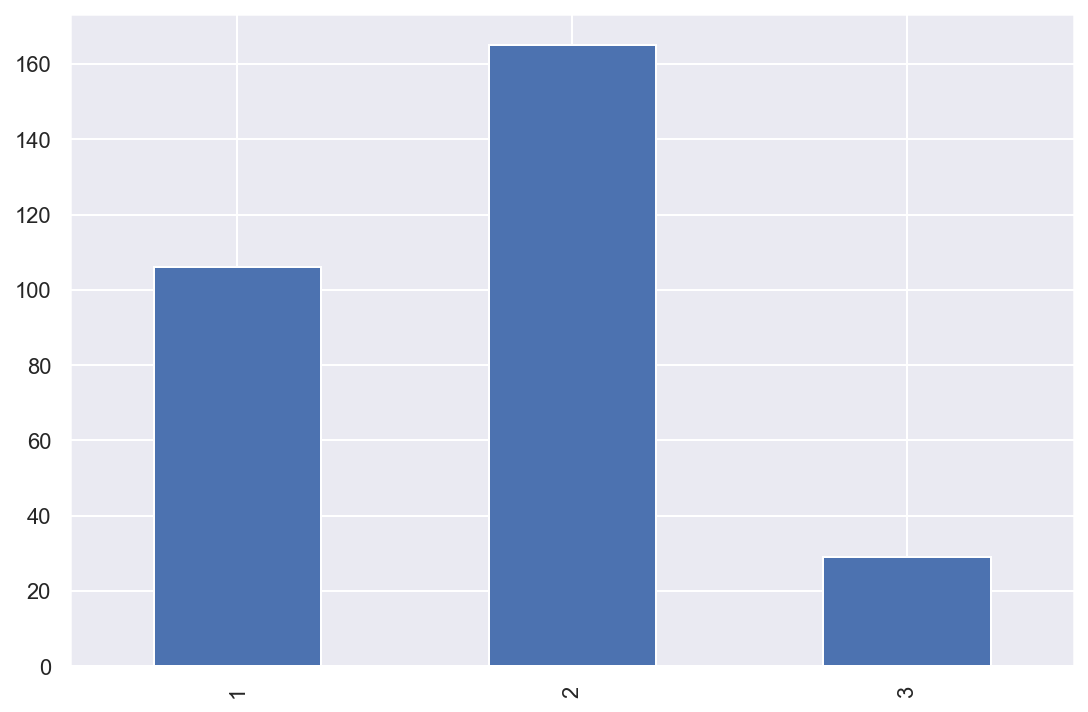

In [227]:
Dapp_cat_imputed.V13.value_counts().sort_index().plot(kind = "bar")
#en pratique, il est nécessaire de vérifier la distribution des variables avant\après imputation
#on trace donc des barplot pour avoir une idée

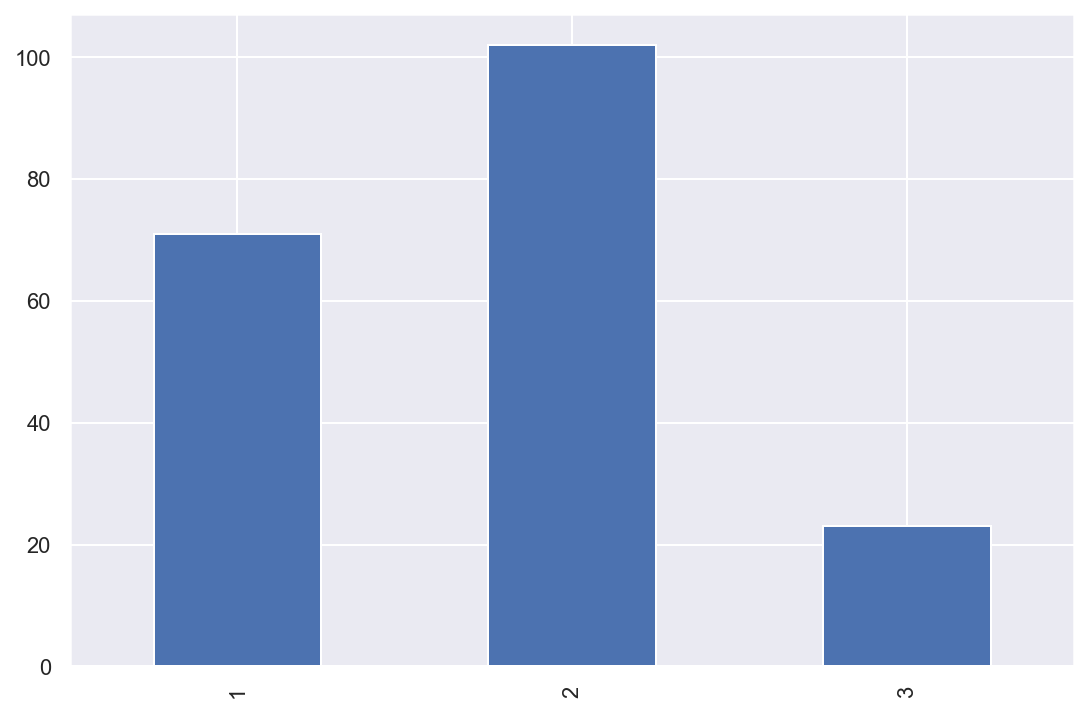

In [226]:
Dapp_cat["V13"].value_counts().sort_index().plot(kind = "bar")

In [219]:
Dapp_imputed = pd.concat([Dapp_num_imputed.reset_index(drop=True), Dapp_cat_imputed], axis=1)
Dapp_imputed.columns = [int(x[1:]) for x in Dapp_imputed.columns]
Dapp_imputed = Dapp_imputed.sort_index(axis = 1)
Dapp_imputed.columns = ["V"+str(x) for x in Dapp_imputed.columns]

Dtest_imputed = pd.concat([Dtest_num_imputed.reset_index(drop=True), Dtest_cat_imputed], axis=1)
Dtest_imputed.columns = [int(x[1:]) for x in Dtest_imputed.columns]
Dtest_imputed = Dtest_imputed.sort_index(axis = 1)
Dtest_imputed.columns = ["V"+str(x) for x in Dtest_imputed.columns]
Dtest_imputed

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21
0,2,1,528626,38.5,54.0,20.0,3,1,2,2,...,1,2,2,5.90,4,2,42.0,6.3,2,4.71
1,2,1,527950,37.6,48.0,36.0,1,1,1,1,...,2,2,1,5.09,3,5,44.0,6.3,1,5.00
2,1,1,535263,37.7,44.0,28.0,3,4,3,2,...,4,1,1,2.28,3,5,45.0,70.0,3,2.00
3,1,1,534523,37.0,56.0,24.0,3,1,4,2,...,3,1,1,1.63,4,5,35.0,61.0,3,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2,1,528452,37.8,42.0,40.0,1,1,1,1,...,1,2,1,6.82,3,3,36.0,6.2,1,3.20
65,1,1,534783,38.0,60.0,12.0,1,1,2,1,...,1,1,1,2.18,1,4,44.0,65.0,3,2.00
66,2,1,528926,38.0,42.0,12.0,3,1,3,1,...,1,2,1,6.05,4,1,37.0,5.8,2,2.74
67,2,1,530670,37.6,88.0,36.0,3,1,1,1,...,2,1,3,1.50,4,4,44.0,6.0,2,10.82


In [221]:
Dtest

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21
0,2,1,528626,38.5,54.0,20.0,NaN,1,2,2,...,1,2,2,5.9,NaN,2,42.0,6.3,NaN,NaN
1,2,1,527950,37.6,48.0,36.0,NaN,NaN,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,44.0,6.3,1,5.0
2,1,1,535263,37.7,44.0,28.0,NaN,4,3,2,...,4,1,1,NaN,3,5,45.0,70.0,3,2.0
3,1,1,534523,37.0,56.0,24.0,3,1,4,2,...,3,1,1,NaN,NaN,NaN,35.0,61.0,3,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2,1,528452,37.8,42.0,40.0,1,1,1,1,...,1,NaN,NaN,NaN,3,3,36.0,6.2,NaN,NaN
65,1,1,534783,38.0,60.0,12.0,1,1,2,1,...,1,1,1,NaN,1,4,44.0,65.0,3,2.0
66,2,1,528926,38.0,42.0,12.0,3,NaN,3,1,...,1,NaN,NaN,NaN,NaN,1,37.0,5.8,NaN,NaN
67,2,1,530670,37.6,88.0,36.0,3,1,1,1,...,2,1,3,1.5,NaN,NaN,44.0,6.0,NaN,NaN
